In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np

# Embeddings
drug_emb = np.load("/content/drive/MyDrive/ADR/drug_chemberta_embeddings.npy")
adr_emb = np.load("/content/drive/MyDrive/ADR/adr_bert_embeddings.npy")

# Names (for indexing)
cid_df = pd.read_csv("/content/drive/MyDrive/ADR/drug_cids.csv")       # column: CID
adr_names = pd.read_csv("/content/drive/MyDrive/ADR/adr_names.csv")    # column: ADR

# Positive drug-ADR pairs
se_df = pd.read_csv("/content/drive/MyDrive/ADR/meddra_all_se.tsv", sep="\t", header=None)
print(se_df.head())
se_df.columns = ["UMLS_ID", "STITCH_CID", "UMS_Concept_ID", "Source", "Noname","ADR"]
se_df["CID"] = se_df["STITCH_CID"].str.extract(r"CID(\d+)").astype(float).astype(int)


              0             1         2    3         4                      5
0  CID100000085  CID000010917  C0000729  LLT  C0000729       Abdominal cramps
1  CID100000085  CID000010917  C0000729   PT  C0000737         Abdominal pain
2  CID100000085  CID000010917  C0000737  LLT  C0000737         Abdominal pain
3  CID100000085  CID000010917  C0000737   PT  C0687713  Gastrointestinal pain
4  CID100000085  CID000010917  C0000737   PT  C0000737         Abdominal pain


In [ ]:
cid_to_index = {cid: i for i, cid in enumerate(cid_df["CID"].tolist())}
adr_to_index = {adr: i for i, adr in enumerate(adr_names["ADR"].tolist())}
print(adr_to_index)


{'Abdominal cramps': 0, 'Abdominal pain': 1, 'Gastrointestinal pain': 2, 'Amblyopia': 3, 'Anaemia': 4, 'Anorexia': 5, 'Decreased appetite': 6, 'Anxiety': 7, 'Arrhythmia': 8, 'Asthenia': 9, 'Atrial fibrillation': 10, 'Back pain': 11, 'Bronchitis': 12, 'Cardiovascular disorder': 13, 'Chest pain': 14, 'Infection': 15, 'Constipation': 16, 'Cough': 17, 'Depression': 18, 'Diarrhoea': 19, 'Dizziness': 20, 'Dysgeusia': 21, 'Dyspepsia': 22, 'Dyspnoea': 23, 'Rash': 24, 'Dermatitis': 25, 'Eye disorder': 26, 'Body temperature increased': 27, 'Gastritis': 28, 'Gastrointestinal disorder': 29, 'Headache': 30, 'Haemorrhage': 31, 'Haemoglobin': 32, 'Hypercalcaemia': 33, 'Hyperkalaemia': 34, 'Hypersensitivity': 35, 'Hypertension': 36, 'Hypotension': 37, 'Influenza': 38, 'Cramps of lower extremities': 39, 'Muscle spasms': 40, 'Melaena': 41, 'Hypertonia': 42, 'Nausea': 43, 'Pain': 44, 'Palpitations': 45, 'Parathyroid disorder': 46, 'Paraesthesia': 47, 'Pharyngitis': 48, 'Pruritus': 49, 'Renal failure': 50

In [ ]:
X = []
y = []

# (label = 1)
for _, row in se_df.iterrows():
    cid = row["CID"]

    adr = row["ADR"]
    i = cid_to_index.get(cid)
    j = adr_to_index.get(adr)

    if i is not None and j is not None and i < drug_emb.shape[0] and j < adr_emb.shape[0]:

        emb = np.concatenate([drug_emb[i], adr_emb[j]])
        X.append(emb)
        y.append(1)
print(drug_emb)

[[ 0.16817354  0.3299545   0.07169016 ... -1.0079659   0.3280256
   0.44529438]
 [ 0.09658169  0.05407649  0.02840664 ... -0.82175446  0.09129934
   0.59846616]
 [ 0.87618417  1.3676727  -0.4753915  ... -0.36566484  0.70811236
   0.6487112 ]
 ...
 [ 0.0976189  -0.1980038  -0.39914408 ... -0.17909084 -0.21370248
   0.17962587]
 [ 0.26235667 -0.03496923 -0.44675636 ... -0.11006451 -0.44700935
   0.46772873]
 [ 0.42451265 -0.01394788 -0.28026542 ... -0.20870386 -0.45218188
   0.51969475]]


In [ ]:
# (label = 0)
import random
all_adrs = set(adr_to_index.keys())

pos_pairs = set(zip(se_df["CID"], se_df["ADR"]))

for _ in range(len(y)):  #length equals to positive labels
    while True:
        cid = random.choice(cid_df["CID"].tolist())
        adr = random.choice(list(all_adrs))
        if (cid, adr) not in pos_pairs:
            i = cid_to_index.get(cid)
            j = adr_to_index.get(adr)
            if i is not None and j is not None and i < drug_emb.shape[0] and j < adr_emb.shape[0]:
                emb = np.concatenate([drug_emb[i], adr_emb[j]])
                X.append(emb)
                y.append(0)
                break


In [ ]:
n = len(X)
sample_size = int(0.8 * n)
indices = np.random.choice(n, size=sample_size, replace=False)
X = np.array(X)
y = np.array(y)

X = X[indices]
y = y[indices]
X.shape

(482672, 1536)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

X = np.array(X)
y = np.array(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.91      0.89      0.90     48273
           1       0.89      0.92      0.90     48262

    accuracy                           0.90     96535
   macro avg       0.90      0.90      0.90     96535
weighted avg       0.90      0.90      0.90     96535



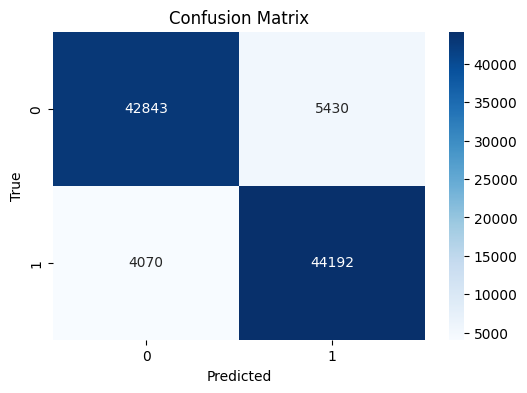

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    confusion_matrix, roc_curve, auc,
    precision_recall_curve, average_precision_score
)

from sklearn.datasets import make_classification

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
import matplotlib.pyplot as plt

def analysis_func(y, y_hat, url=None):
    y = np.array(y, dtype=int)
    y_hat = np.array(y_hat, dtype=int)

    # confusion matrix
    TP = np.sum((y == 1) & (y_hat == 1))
    TN = np.sum((y == 0) & (y_hat == 0))
    FP = np.sum((y == 0) & (y_hat == 1))
    FN = np.sum((y == 1) & (y_hat == 0))

    values = {'TP': TP, 'TN': TN, 'FP': FP, 'FN': FN}

    recall = round(TP / (TP + FN), 2) if (TP + FN) > 0 else 0.0
    precision = round(TP / (TP + FP), 2) if (TP + FP) > 0 else 0.0
    accuracy = round((TP + TN) / (TP + TN + FP + FN), 2)
    F1 = round((2 * recall * precision) / (recall + precision), 2) if (recall + precision) > 0 else 0.0

    result = {'values': values, 'Accuracy': accuracy, 'Precision': precision, 'Recall': recall, 'F1': F1}

    #draw the table
    data = [
        ["Predicted Negative", "Predicted Positive", ""],
        ['FN = ' + str(result['values']['FN']), 'TP = ' + str(result['values']['TP']), "Actual Positive"],
        ['TN = ' + str(result['values']['TN']), 'FP = ' + str(result['values']['FP']), "Actual Negative"]
    ]
    text = ""
    for key, val in result.items():
        if key != 'values':
            text += key + ': ' + str(val) + '    '

    fig, ax = plt.subplots(figsize=(8, 1.5))

    ax.axis('tight')
    ax.axis('off')

    table = ax.table(cellText=data, loc='center', cellLoc='center')

    table.auto_set_font_size(False)
    table.set_fontsize(12)

    table.scale(1, 1.5)
    for (row, col), cell in table.get_celld().items():
        cell.set_edgecolor('white')
        if(not(row == 0 and col == 2)):
            if( (row == 0 or col == 2)):
                cell.set_facecolor('#8d84d7')
            else:
                cell.set_facecolor('#ccc9e4')

    # plt.tight_layout(pad=0.01)
    plt.text(-.05, -.06, text)
    if(url != None):
        plt.savefig(url, dpi=200,bbox_inches='tight')
    plt.show()

    return result

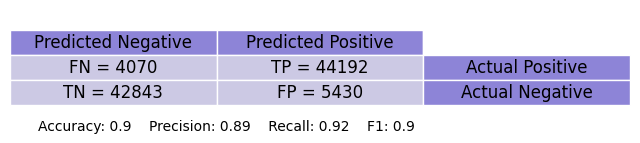

{'values': {'TP': np.int64(44192),
  'TN': np.int64(42843),
  'FP': np.int64(5430),
  'FN': np.int64(4070)},
 'Accuracy': np.float64(0.9),
 'Precision': np.float64(0.89),
 'Recall': np.float64(0.92),
 'F1': np.float64(0.9)}

In [ ]:
analysis_func(y_test, y_pred)

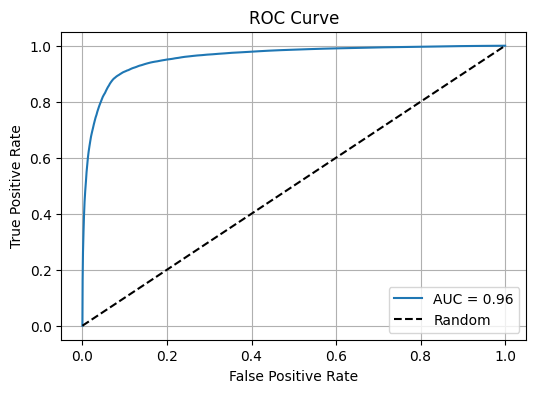

In [ ]:
y_proba = clf.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid(True)
plt.show()


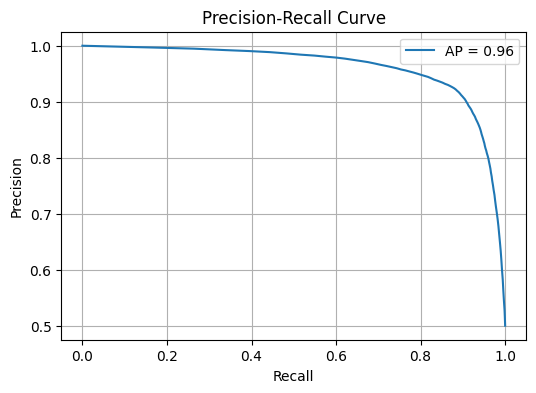

In [ ]:
precision, recall, _ = precision_recall_curve(y_test, y_proba)
ap = average_precision_score(y_test, y_proba)

plt.figure(figsize=(6,4))
plt.plot(recall, precision, label=f'AP = {ap:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    confusion_matrix, roc_curve, auc,
    precision_recall_curve, average_precision_score
)